In [177]:
import pandas as pd
import numpy as np 
import gluonts
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Config

In [178]:
days_ahead = 11

# Load data

In [179]:
ts60 = pd.read_csv('../../VEOLIA/artifacts/timeseries_60min.csv', index_col=0, parse_dates=True)[datetime.datetime(2020, 11, 6):]
ts60.head(3)

,Diff Load Activa Total (60 minuto),Diff Load Primario ACS (60 minuto),Diff Load Consumo ACS (60 minuto),Diff Load Caldera 1 (60 minuto),Diff Load Caldera 2 (60 minuto),True Load Caldera 1 (60 minuto),True Load Caldera 2 (60 minuto),True Load Primario ACS (60 minuto),True Load Consumo ACS (60 minuto),Energía Caldera 1 (60 minuto),...,TEMPERATURA DEPOSITO 2 ACS (60 minuto),DEMANDA CALEFACCIÓN (60 minuto),DEMANDA ACS (60 minuto),DEMANDA QUEMADORES (60 minuto),Caudal Caldera 1 (60 minuto),Caudal Caldera 2 (60 minuto),Caudal Primario ACS (60 minuto),Caudal Consumo ACS (60 minuto),CONTADOR GAS CALDERA 1 (60 minuto),CONTADOR GAS CALDERA 2 (60 minuto)
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-06 00:00:00,2600.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,38.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6705.2,12467.6
2020-11-06 01:00:00,2610.0,10.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,38.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6723.8,12467.6
2020-11-06 02:00:00,2570.0,20.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,38.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6736.1,12467.6


In [180]:
calendar60 = pd.read_csv('../VEOLIA/artifacts/time_60min.csv', index_col=1, parse_dates=True)[datetime.datetime(2020, 11, 6):].drop(columns='Unnamed: 0')
calendar60.head(3)

,year,month,day,hour,minute,second,weekday,weekend,holiday
datetime,,,,,,,,,
2020-11-06 00:00:00,2020,11,6,0,0,0,4,False,False
2020-11-06 01:00:00,2020,11,6,1,0,0,4,False,False
2020-11-06 02:00:00,2020,11,6,2,0,0,4,False,False


In [181]:
weather60 = pd.read_csv('../VEOLIA/artifacts/weather_curated_60min.csv', index_col=0, parse_dates=True)[datetime.datetime(2020, 11, 1):]
weather60.head(3)

,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id
datetime,,,,,,,,,,,,,
2020-11-01 00:00:00,9.42,9.42,7.63,10.36,1028,99,1.0,140,0.0,0.0,0.0,0,800
2020-11-01 01:00:00,9.96,8.41,7.73,11.47,1028,96,3.1,180,0.0,0.0,0.0,0,800
2020-11-01 02:00:00,10.31,9.93,8.03,11.47,1027,97,5.7,190,0.0,0.0,0.0,0,800


## Transform to gluonts dataset

In [165]:
# define the parameters / metadata of the dataset
prediction_length = days_ahead * 24
freq = "1H"
starts = [pd.Timestamp("11-06-2020", freq=freq) 
          if 'Energ' in x or 'Contador' in x or 'Diff' in x
            else pd.Timestamp("05-16-2021", freq=freq)
            for x in ts60.columns
         ]   # can be different for each time series
training_indices = ts60.index[:-prediction_length]

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train = ListDataset(
    [{'target': ts60.loc[training_indices][x].dropna(), 'start': start, 'item_id': x}
        for x in ts60.columns for start in starts],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test = ListDataset(
    [{'target': ts60[x].dropna(), 'start': start, 'item_id': x}
        for x in ts60.columns for start in starts],
    freq=freq
)


C:\Users\spele\AppData\Local\Temp/ipykernel_12104/3626647103.py:3: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  starts = [pd.Timestamp("11-06-2020", freq=freq)
C:\Users\spele\AppData\Local\Temp/ipykernel_12104/3626647103.py:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  else pd.Timestamp("05-16-2021", freq=freq)


In [166]:
# get the first time series in the training set
train_entry = next(iter(train))
print(train_entry.keys())
test_entry = next(iter(test))
print(test_entry.keys())

dict_keys(['target', 'start', 'item_id', 'source'])
dict_keys(['target', 'start', 'item_id', 'source'])


c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\gluonts\dataset\util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


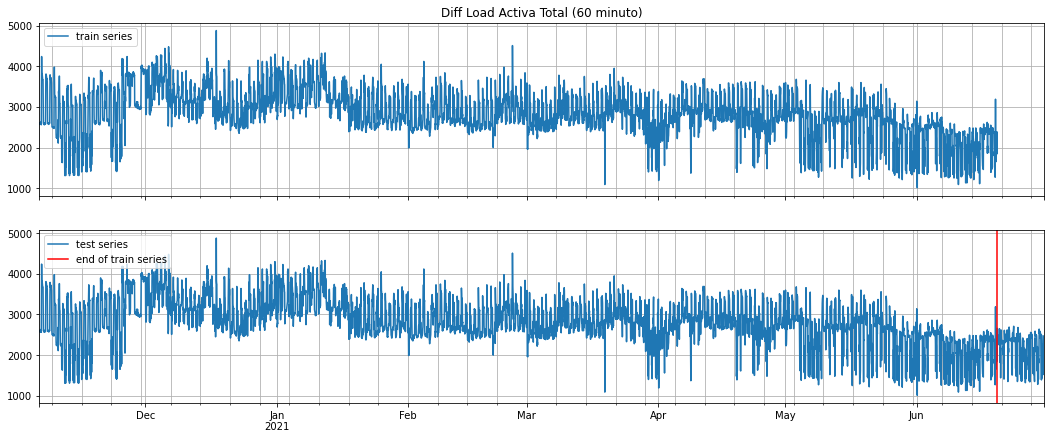

In [167]:
test_series = to_pandas(test_entry)
test_series.name = test_entry['item_id']
train_series = to_pandas(train_entry)
train_series.name = train_entry['item_id']

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(18, 7))

train_series.plot(ax=ax[0], title=train_series.name)
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r')  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()